In [1]:
import numpy as np 
import pandas as pd
import geopandas as gpd
import shapely
from shapely.wkt import loads
import shapely.vectorized as sv 
from scipy.spatial.distance import cdist 
from shapely.geometry import shape, Point, LineString, Polygon
from osgeo import ogr
import fiona
import osmnx as ox
import matplotlib.pyplot as plt

In [2]:
# conda install -y -c conda-forge osmnx
# pip install geopandas descartes shapely fiona pyproj six

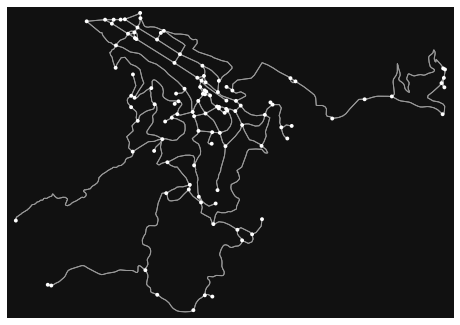

In [3]:
place_name = "Woodacre, CA, USA"
graph = ox.graph_from_place(place_name)
nodes, edges = ox.graph_to_gdfs(graph)
fig, ax = ox.plot_graph(graph)
for _, edge in ox.graph_to_gdfs(graph, nodes=False).fillna('').iterrows():
    c = edge['geometry'].centroid
    text = edge['name']
    ax.annotate(text, (c.x, c.y), c='w')
plt.show()
# nodes, edges = ox.graph_to_gdfs(graph)

In [4]:
# fig, ax = ox.plot_graph(graph)
# plt.tight_layout()
# edges.plot(ax=ax, linewidth=1, edgecolor='#BC8F8F')


In [5]:
nodes = nodes.reset_index()
nodes = nodes.rename(columns = {'Unnamed: 0': 'nid' })
nodes = nodes.rename(columns = {'y': 'lat', 'x': 'lon'})
nodes = nodes.reset_index()
nodes = nodes.rename(columns = {'index':'nid'})
nodes.to_csv('../network_inputs/osm_nodes_woodacre.csv', index = False)
# nodes = nodes.rename(columns = {'index':'nid'})


In [6]:
# nodes = pd.read_csv('../network_inputs/osm_nodes_woodacre.csv')

In [7]:
# nodes.head()
# east_lat = min(nodes['y'])
# west_lat = max(nodes['y'])
# north_lon = max(nodes['x'])
# south_lon = min(nodes['x'])
# east = nodes[nodes['y'] == east_lat]
# west = nodes[nodes['y'] == west_lat]
# north = nodes[nodes['x'] == north_lon]
# south = nodes[nodes['x'] == south_lon]

In [8]:
nodes.head()

,nid,osmid,lat,lon,street_count,geometry
0,0,110355652,38.012898,-122.644565,3,POINT (-122.64457 38.01290)
1,1,110355759,38.012060,-122.643405,5,POINT (-122.64341 38.01206)
2,2,110359283,38.004565,-122.632768,3,POINT (-122.63277 38.00456)
3,3,110370198,38.007508,-122.639722,3,POINT (-122.63972 38.00751)
4,4,110370204,38.007339,-122.640039,1,POINT (-122.64004 38.00734)


In [9]:
edges.reset_index(inplace = True)
# edges = nodes.rename(columns = {'Unnamed: 0': 'nid' })

In [10]:
edges = edges.rename(columns = {'u': 'start_osm', 'v': 'end_osm','maxspeed': 'maxmph' })


In [11]:
edges['maxmph'] = edges['maxmph'].replace('35 mph', 35)
edges['maxmph'] = edges['maxmph'].replace(np.nan, 25)
edges.maxmph.value_counts()

25.0    296
35.0      4
Name: maxmph, dtype: int64

In [40]:
# edges.length.unique()
edges['lanes'] = edges['lanes'].replace(np.nan, 1)
edges.lanes.value_counts()

1.0    296
2.0      4
Name: lanes, dtype: int64

In [41]:
edges = edges.rename(columns = {'u': 'start_osm', 'v': 'end_osm','maxspeed': 'maxmph' })

In [42]:
edges['eid']=list(edges.index)

In [43]:
edges = edges.rename(columns = {'osmid': 'edge_osmid'})
edges = edges.rename(columns = {'highway': 'type'})

In [44]:
nodes.head()

,nid,osmid,lat,lon,street_count,geometry
0,0,110355652,38.012898,-122.644565,3,POINT (-122.64457 38.01290)
1,1,110355759,38.012060,-122.643405,5,POINT (-122.64341 38.01206)
2,2,110359283,38.004565,-122.632768,3,POINT (-122.63277 38.00456)
3,3,110370198,38.007508,-122.639722,3,POINT (-122.63972 38.00751)
4,4,110370204,38.007339,-122.640039,1,POINT (-122.64004 38.00734)


In [45]:
# using dictionary comprehension
# to convert lists to dictionary
nid = list(nodes['nid'])
osm_nid = list(nodes['osmid'])
res = {osm_nid[i]: nid[i] for i in range(len(osm_nid))}

In [46]:
# res
def getNodeID_start(r):
    return res[r['start_osm']]

def getNodeID_end(r):
    return res[r['end_osm']]

In [47]:
edges['nid_s'] = edges.apply(getNodeID_start, axis=1 )
edges['nid_e'] = edges.apply(getNodeID_end, axis=1 )

In [48]:
edges.to_csv('../network_inputs/osm_edges_woodacre.csv', index = False)

In [20]:
# edges['type']= edges.type.astype(str)
edges = pd.read_csv('../network_inputs/osm_edges_woodacre.csv')

In [21]:
edges

,start_osm,end_osm,key,edge_osmid,name,type,oneway,length,access,geometry,service,lanes,maxmph,eid,nid_s,nid_e
0,110355652,8156954912,0,12189220,San Geronimo Valley Drive,residential,False,51.137,NaN,"LINESTRING (-122.6445655 38.0128977, -122.6451...",NaN,NaN,25.0,0,0,104
1,110355652,110442476,0,12189220,San Geronimo Valley Drive,residential,False,31.236,NaN,"LINESTRING (-122.6445655 38.0128977, -122.6442...",NaN,NaN,25.0,1,0,61
2,110355759,110377358,0,620535165,Park Street,residential,False,41.343,NaN,"LINESTRING (-122.6434051 38.0120605, -122.6431...",NaN,NaN,25.0,2,1,10
3,110355759,2393115846,0,12171454,NaN,service,False,62.127,private,"LINESTRING (-122.6434051 38.0120605, -122.6432...",NaN,NaN,25.0,3,1,77
4,110355759,2393115847,0,12174469,Park Street,residential,False,43.204,NaN,"LINESTRING (-122.6434051 38.0120605, -122.6434...",NaN,NaN,25.0,4,1,78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,8280616022,2630144530,0,12190658,Fire Road,residential,False,570.907,NaN,"LINESTRING (-122.6352081 38.0082197, -122.6351...",NaN,NaN,25.0,295,109,93
296,8280616022,110408698,0,"[12190658, 12186418]","['Fire Road', 'Pine Avenue']",residential,False,201.307,NaN,"LINESTRING (-122.6352081 38.0082197, -122.6352...",NaN,NaN,25.0,296,109,33
297,8280616022,8280616030,0,890942644,NaN,service,False,50.766,NaN,"LINESTRING (-122.6352081 38.0082197, -122.6352...",NaN,NaN,25.0,297,109,110
298,8280616030,8280616022,0,890942644,NaN,service,False,50.766,NaN,"LINESTRING (-122.6356992 38.0084577, -122.6355...",NaN,NaN,25.0,298,110,109


In [22]:
# nodes.reset_index()['osmid'].unique()

In [23]:
# import csv,sys
# from osgeo import ogr
# from osgeo import osr
# shpfile= 'parcels/parcel_woodacre/Parcel.shp' #sys.argv[1]
# csvfile= 'parcels/parcel_woodacre/parcels_woodacre.csv' #sys.argv[2]

# # input SpatialReference
# inSpatialRef = osr.SpatialReference()
# inSpatialRef.ImportFromEPSG(2872)

# # output SpatialReference
# outSpatialRef = osr.SpatialReference()
# outSpatialRef.ImportFromEPSG(4326)

# # create the CoordinateTransformation
# coordTrans = osr.CoordinateTransformation(inSpatialRef, outSpatialRef)

# #Open files
# csvfile=open(csvfile,'w')
# ds=ogr.Open(shpfile)
# lyr=ds.GetLayer()

# #Get field names
# dfn=lyr.GetLayerDefn()
# nfields=dfn.GetFieldCount()
# fields=[]
# for i in range(nfields):
#     fields.append(dfn.GetFieldDefn(i).GetName())
# fields.append('kmlgeometry')
# csvwriter = csv.DictWriter(csvfile, fields)
# try:csvwriter.writeheader() #python 2.7+
# except:csvfile.write(','.join(fields)+'\n')

# # Write attributes and kml out to csv
# for feat in lyr:
#     attributes=feat.items()
#     geom=feat.GetGeometryRef()
#     geom.Transform(coordTrans)
# #     spatialRef = geom.GetSpatialReference()
# #     spatialRef.ImportFromEPSG(2872)
# #     print(geom.ExportToWkt())
#     attributes['kmlgeometry']=geom.ExportToWkt()
#     csvwriter.writerow(attributes)

# #clean up
# del csvwriter,lyr,ds
# csvfile.close()

In [24]:
# woodacre_parcels = pd.read_csv('parcels/parcel_woodacre/parcels_woodacre.csv')
# woodacre_parcels

In [26]:
# read Woodacre nodes
nodes_df = pd.read_csv('../network_inputs/osm_nodes_woodacre.csv')
nodes_gdf = gpd.GeoDataFrame(nodes_df, geometry=[shapely.geometry.Point(xy) for xy in zip(nodes_df.lat, nodes_df.lon)], crs='epsg:4326')
display(nodes_gdf.head(2))
# # read visitor nodes
# visitor_nodes_df = pd.read_csv('../network_inputs/osm_nodes_visitor_parking.csv')
# visitor_nodes_gdf = gpd.GeoDataFrame(visitor_nodes_df, geometry=[shapely.geometry.Point(xy) for xy in zip(visitor_nodes_df.lon, visitor_nodes_df.lat)], crs='epsg:4326')
# display(visitor_nodes_gdf.head(2))

,nid,osmid,lat,lon,street_count,geometry
0,0,110355652,38.012898,-122.644565,3,POINT (38.013 -122.645)
1,1,110355759,38.012060,-122.643405,5,POINT (38.012 -122.643)


In [29]:
east = nodes_gdf[nodes_gdf['lat'] == east_lat]
west = nodes_gdf[nodes_gdf['lat'] == west_lat]
north = nodes_gdf[nodes_gdf['lon'] == north_lon]
south = nodes_gdf[nodes_gdf['lon'] == south_lon]
south, north, east, west

NameError: name 'east_lat' is not defined

In [30]:
### Get the OSMid of the closest node to each parcel
woodacre_parcels = pd.read_csv('parcels/parcel_woodacre/parcels_woodacre.csv')
woodacre_parcels.head()
household_parcels = woodacre_parcels[woodacre_parcels['UseCd']==11].reset_index() ### only UseCd 11 has household size>0 (=1)
household_parcels = gpd.GeoDataFrame(household_parcels, crs='epsg:4326',
                                     geometry=household_parcels['kmlgeometry'].apply(loads))

household_parcels['centroid'] = household_parcels.apply(lambda x: x['geometry'].centroid, axis=1)
household_parcels = household_parcels.set_geometry('centroid')
household_parcels['c_x'] = household_parcels['centroid'].x
household_parcels['c_y'] = household_parcels['centroid'].y
nodes_xy = np.array([nodes_gdf['geometry'].x.values, nodes_gdf['geometry'].y.values]).transpose()
nodes_osmid = nodes_gdf['osmid'].values

def get_closest_node(parcel_x, parcel_y):
    return nodes_osmid[cdist([(parcel_x, parcel_y)], nodes_xy).argmin()]

household_parcels['closest_node'] = household_parcels.apply(lambda x: get_closest_node(x['c_x'], x['c_y']), axis=1)
display(household_parcels.head(2))
household_parcels.shape
# parcels_evac.to_csv(absolute_path+'/outputs/parcels_evac_woodacre.csv', index=False)


,index,OBJECTID,Acres,PropID,UseCd,UseCdDesc,Jurisdicti,SHAPESTAre,SHAPESTLen,kmlgeometry,geometry,centroid,c_x,c_y,closest_node
0,3,93,0.189,172-343-11,11,Single-Resid. - Improved,Unincorporated,8238.644531,367.468845,"POLYGON ((37.9988741699523 -122.633908015741,3...","POLYGON ((37.999 -122.634, 37.999 -122.634, 37...",POINT (37.999 -122.634),37.998810,-122.634132,1705290936
1,4,108,0.591,176-112-02,11,Single-Resid. - Improved,Unincorporated,25785.556641,698.414121,"POLYGON ((38.0148666598009 -122.592662801265,3...","POLYGON ((38.015 -122.593, 38.015 -122.592, 38...",POINT (38.015 -122.593),38.014629,-122.592733,2006817311


(2462, 15)

In [31]:
random_seed = 0
np.random.seed(random_seed)
vphh = 1
visitor_cnts = 0 ### 300 vehicles
commscen_id = 1

direction = {'south': 8398747289,
'north': 2006817311,
'east': 2882876550,
'west': 110377352 }

### local residents origin
local_residents_od_df = household_parcels[['OBJECTID', 'closest_node']].copy().sample(frac=1).reset_index(drop=True)
local_residents_od_df['origin_osmid'] = local_residents_od_df['closest_node']
local_residents_od_df = local_residents_od_df.drop('closest_node', 1)
local_residents_od_df['dept_time'] = 0
local_residents_od_df['type'] = 'local'

### visitor origin
# visitor_vehicle_origin = np.random.choice(visitor_nodes_gdf['node_osmid'], size=visitor_cnts)
# visitor_vehicle_od_df = pd.DataFrame({'origin_osmid': visitor_vehicle_origin})
# visitor_vehicle_od_df = visitor_vehicle_od_df.sample(frac=1).reset_index(drop=True)
# visitor_vehicle_od_df['dept_time'] = 0
# visitor_vehicle_od_df['type'] = 'visitor'
# visitor_vehicle_od_df['Parcel'] = None
od_df = local_residents_od_df


### set destination
od_df['destin_osmid'] = int(direction['south'])
#od_df['destin_osmid'] = np.random.choice(['110360959', '110397253'], size=od_df.shape[0])

### save to output
od_df.to_csv( 'od_csv/resident_visitor_od_vphh{}_visitor{}.csv'.format(vphh, visitor_cnts), index=False)



                #+[visitor_vehicle_od_df])
# od_df
# if communication scenario 1, can go north or south
                  
# if (commscen_id == 0):
#     od_df['destin_osmid'] = np.random.choice(['110360959', '110397253'], size=od_df.shape[0])
# else:
#     od_df['destin_osmid'] = '110397253'
# od_df.to_csv('od_csv/resident_visitor_od_rs{}_vphh{}_visitor{}_comm{}.csv'.format(random_seed, vphh, visitor_cnts, commscen_id), index=False)

In [32]:
od_df

,OBJECTID,origin_osmid,dept_time,type,destin_osmid
0,63212,8398747289,0,local,8398747289
1,93349,2393115846,0,local,8398747289
2,8381,3552151798,0,local,8398747289
3,10111,3552151798,0,local,8398747289
4,93593,110389269,0,local,8398747289
...,...,...,...,...,...
2457,10437,3552151798,0,local,8398747289
2458,62961,8398747289,0,local,8398747289
2459,9676,3552151798,0,local,8398747289
2460,9909,3552151798,0,local,8398747289


In [31]:
od_df

[      OBJECTID  origin_osmid  dept_time   type
 0        63212    8398747289          0  local
 1        93349    2393115846          0  local
 2         8381    3552151798          0  local
 3        10111    3552151798          0  local
 4        93593     110389269          0  local
 ...        ...           ...        ...    ...
 2457     10437    3552151798          0  local
 2458     62961    8398747289          0  local
 2459      9676    3552151798          0  local
 2460      9909    3552151798          0  local
 2461     60265    2006817311          0  local
 
 [2462 rows x 4 columns]]

## Extra 

In [ ]:
# import json

# # df_places = gpd.read_file('parcels/parcel_woodacre/woodacre_parcel1.json',driver="GeoJSON")
# # Opening JSON file
# f = open('parcels/parcel_woodacre/woodacre_parcel1.json',)
  
# # returns JSON object as 
# # a dictionary
# data = json.load(f)
# # print(data['features'])
# # # Iterating through the json
# # # list
# for i in data['features']:
#     print(i['geometry'])
#     print('\n')
  
# # Closing file
# f.close()

In [38]:
import fiona
shapefile = fiona.open("parcels/parcel_woodacre/Parcel.shp")

driver = shapefile.driver
print('Dataset driver is: {n}\n'.format(n=driver))
### How many features are contained in this Shapefile?
feature_count = len(shapefile)
print('The shapefile has {n} feature(s)\n'.format(n=feature_count))

### What is the shapefiles's projection?
# Get the spatial reference
spatial_ref = shapefile.crs
print('The shapefiles spatial ref is:\n', spatial_ref, '\n')

# Let's pull out a specific feature from the shapefile
feature = shapefile[0]

### What is the features's geometry? is it a point? a polyline? a polygon?
geometry = feature['geometry']['type']
print("The features's geometry is: {geom}\n".format(geom=geometry))

### How many properties are in the shapefile, and what are their names?
properties = feature["properties"].keys()

# How many fields
field_count = len(properties)
print('Layer has {n} fields'.format(n=field_count))

# What are their names?
print('Their names are: ')
for prop in properties:
    print('\t{name}'.format(name=prop))
feature = shapefile[0]
feature['geometry']

Dataset driver is: ESRI Shapefile

The shapefile has 92585 feature(s)

The shapefiles spatial ref is:
 {'init': 'epsg:2872'} 

The features's geometry is: Polygon

Layer has 8 fields
Their names are: 
	OBJECTID
	Acres
	PropID
	UseCd
	UseCdDesc
	Jurisdicti
	SHAPESTAre
	SHAPESTLen


{'type': 'Polygon',
 'coordinates': [[(5977171.669773355, 2166166.021162927),
   (5977168.4396933615, 2166132.75012289),
   (5977165.76244536, 2166133.0093228966),
   (5977163.083405346, 2166133.270186901),
   (5977155.876749352, 2166133.969066903),
   (5977154.329741344, 2166134.11997889),
   (5977152.782733336, 2166134.269226894),
   (5977155.714317352, 2166165.5995309204),
   (5977156.29338935, 2166171.784234926),
   (5977172.079885364, 2166170.2502829283),
   (5977171.874829367, 2166168.1357229203),
   (5977171.669773355, 2166166.021162927)]]}